## Large Data Limits paper
This is just a rough first version, not entirely true to what it should be. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

In [3]:
def run_rescaled_tsne(data, kappa=30, alpha=0.1):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b needs to be larger than 1/d and smaller than 1 
    b = 0.12
    h_n = n ** (-b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=-1,
        random_state=42,
    )
    embedding = tsne.fit(data)
    return embedding


In [4]:
def create_synthetic_data(n_points=10000, n_features=50, n_clusters=5, cluster_std=1.0):
    """
    Generate synthetic data as a mixture of Gaussians.
    """
    np.random.seed(42)
    data = []
    labels = []
    centers = np.random.randn(n_clusters, n_features) * 0.7
    points_per_cluster = n_points // n_clusters
    for i in range(n_clusters):
        points = centers[i] + cluster_std * np.random.randn(points_per_cluster, n_features)
        data.append(points)
        labels.append(np.full(points.shape[0], i))
    data = np.vstack(data)
    labels = np.concatenate(labels)

    indices = np.random.permutation(n_points)
    return data[indices], labels[indices]


In [5]:
def run_standard_tsne(data, perplexity=30, exaggeration=12):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(
        perplexity=perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=4,
        random_state=42,
    )
    return tsne.fit(data)

## Experiments: Varying Samples Sizes - Comparison rescaled and standard t-SNE

In [6]:
data_all, labels_all = create_synthetic_data(n_points=1000000, n_features=50, n_clusters=5)
def comp_rescaled_tsne_on_sizes(data_sizes): 
    for n_fixed in data_sizes: 

        sampled_indices = np.random.choice(len(data_all), size=n_fixed, replace=False)

        # Select the random subset of data and labels
        data_subset = data_all[sampled_indices]
        labels_subset = labels_all[sampled_indices]

        # Standard t-SNE (with constant perplexity and exaggeration)
        emb_standard = run_standard_tsne(data_subset, perplexity=30, exaggeration=12)

        # Rescaled t-SNE (per our new model)
        emb_rescaled = run_rescaled_tsne(data_subset, kappa=30, alpha=0.05)

        # cmap = plt.get_cmap("Set1")

        # Plot side-by-side
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(emb_standard[:, 0], emb_standard[:, 1], c=labels_subset[:n_fixed], cmap="Set1", s=5)
        plt.title(f"Standard t-SNE, {n_fixed} points")
    
        plt.subplot(1, 2, 2)
        plt.scatter(emb_rescaled[:, 0], emb_rescaled[:, 1], c=labels_subset[:n_fixed], cmap="Set1", s=5)
        plt.title(f"Rescaled t-SNE, {n_fixed} points")
    
        plt.tight_layout()
        plt.show()

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.12
Computed h_n = 0.5754
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02


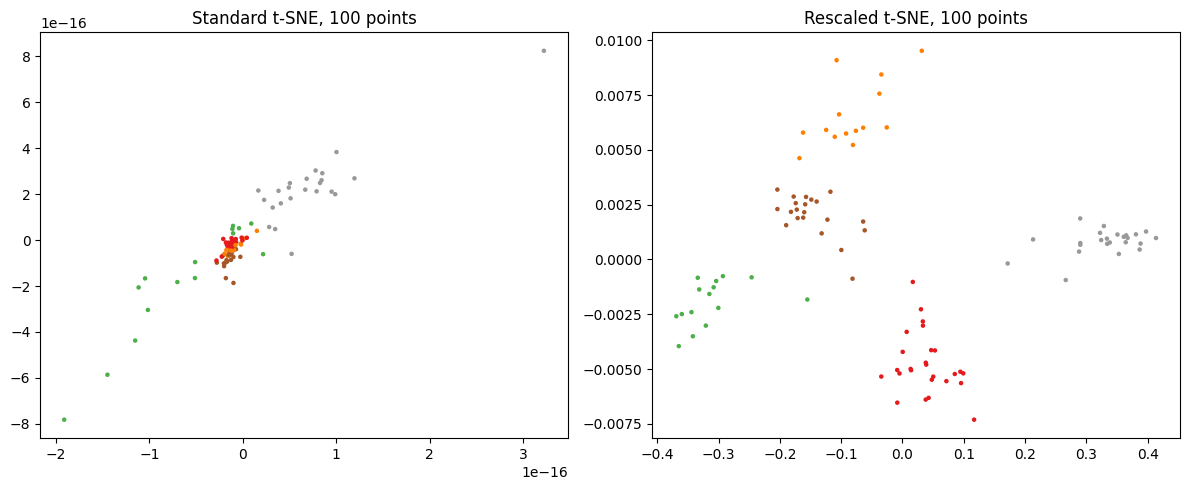

n = 500, d = 50, b=0.12
Computed h_n = 0.4744
Using perplexity = 40.93 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 4.44


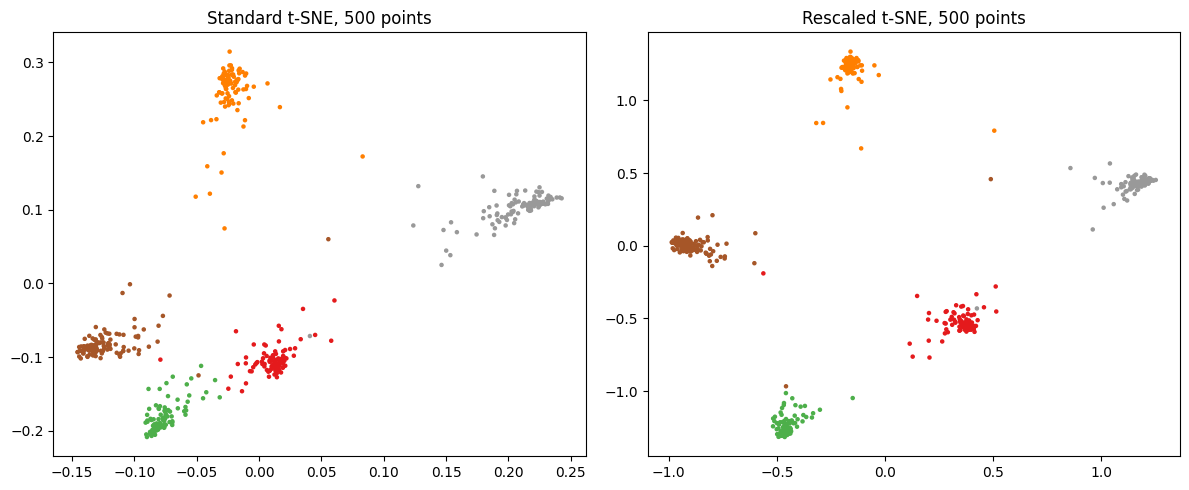

In [7]:
comp_rescaled_tsne_on_sizes([100, 500])

n = 100, d = 50, b=0.1
Computed h_n = 0.6310
Using perplexity = 31.41 (base κ = 30, exponent α = 0.01)
Using early exaggeration = 2.51


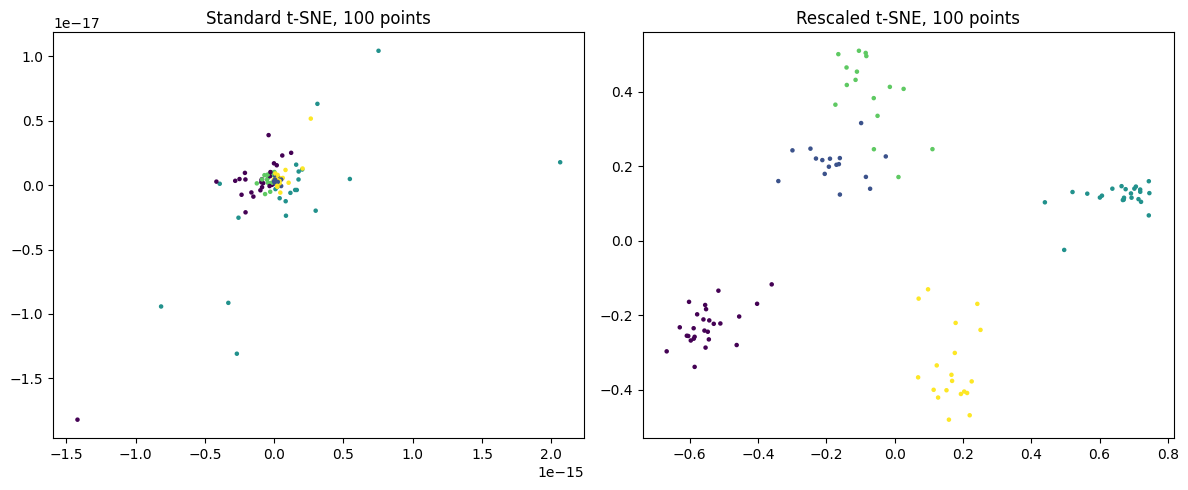

n = 500, d = 50, b=0.1
Computed h_n = 0.5372
Using perplexity = 31.92 (base κ = 30, exponent α = 0.01)
Using early exaggeration = 3.47


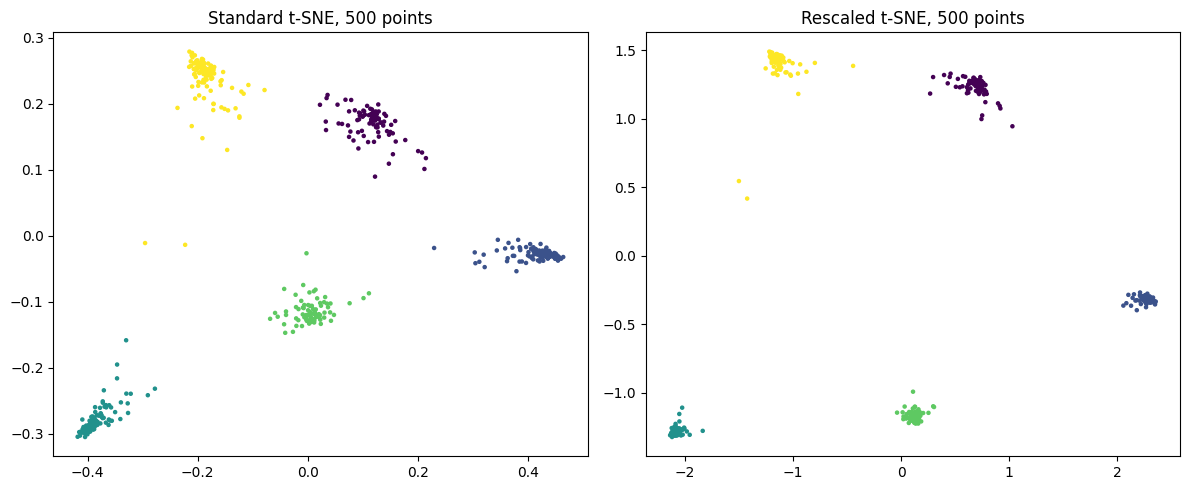

n = 1000, d = 50, b=0.1
Computed h_n = 0.5012
Using perplexity = 32.15 (base κ = 30, exponent α = 0.01)
Using early exaggeration = 3.98


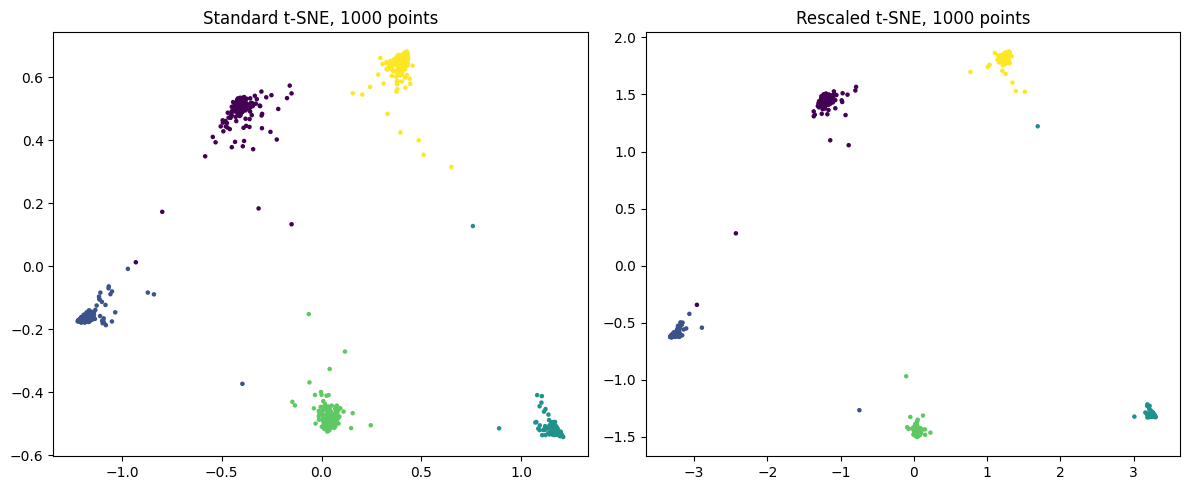

In [ ]:
comp_rescaled_tsne_on_sizes([100, 500, 1000, 10000, 100000, 1000000, 10000000])